In [1]:
%load_ext autoreload
%autoreload 2

import pandas as pd
import numpy as np
from datetime import datetime 
import zipfile
import matplotlib.pyplot as plt
import seaborn as sns

sns.set()

import sys
import io
sys.path.insert(1, "../src")

from FastTest import FastTest
from Exchange import Exchange
from Broker import Broker
from Strategy import *
from Asset import Asset
from Order import *

In [2]:
z = zipfile.ZipFile(r"C:\Users\bktor\Downloads\preds_test.zip")
_file_names = z.namelist()
asset_names = [_file[0:-4] for _file in _file_names]

In [12]:
exchange = Exchange()
broker = Broker(exchange=exchange)

source_type = "zip"
datetime_format = "%Y-%m-%d"
datetime_column = "DATE"

for index, _file in enumerate(_file_names):
    f = z.open(_file)
    exchange.register_asset(Asset(
                asset_names[index],
                source_type = source_type,
                fp = f,
                datetime_format = datetime_format,
                datetime_column = datetime_column,
                frequency = "1D",
                start_date = "2021-10-01",
                #end_date = "2022-02-01"
            )
        )

fast_test = FastTest(
    exchange=exchange,
    broker=broker
)

class AgisStrategy(Strategy):
    def __init__(self, exchange: Exchange, broker: Broker) -> None:
        super().__init__(exchange, broker)
        self.holding_times = {}
        self.lookahead = 20
        self.position_size = 2000

    def check_sale(self, close_all = False):
        orders = []
        for asset_name in list(self.holding_times.keys()):
            self.holding_times[asset_name] += 1
            if self.holding_times[asset_name] == self.lookahead or close_all:
                try:
                    orders.append(
                        MarketOrder(
                        order_create_time = self.exchange.market_time,
                        asset_name = asset_name,
                        units = -1 * self.broker.portfolio[asset_name].units
                        )
                    )
                    del self.holding_times[asset_name]
                except:
                    pass
        return orders

    def next(self):
        predicted_returns = {d : exchange.market_view[d]["Next Return"] for d in list(exchange.market_view.keys())[1:] if d != "SPY"}
        predicted_returns = {k: v for k, v in sorted(predicted_returns.items(), key=lambda item: item[1], reverse = True)}
        if len(predicted_returns) == 0: return []
        avg_predicted_returns = sum(predicted_returns.values())/len(predicted_returns.keys())
        
        #if avg_predicted_returns < 0: return self.check_sale(close_all=True)

        preds = list(predicted_returns.keys())
        holdings = list(self.holding_times.keys())

        for asset_buy in preds:
            if asset_buy not in holdings:
                break
        for asset_sell in preds[::-1]:
            if asset_sell not in holdings:
                break

        new_order_buy = MarketOrder(
            order_create_time = self.exchange.market_time,
            asset_name = asset_buy,
            units = self.position_size / (self.exchange.market_view[asset_buy]["CLOSE"])
        )
        new_order_sell = MarketOrder(
            order_create_time = self.exchange.market_time,
            asset_name = asset_sell,
            units = -1 * (self.position_size / (self.exchange.market_view[asset_sell]["CLOSE"]))
        )
        self.holding_times[asset_buy] = 0
        self.holding_times[asset_sell] = 0
        orders = [new_order_buy, new_order_sell]
        orders += self.check_sale()
        assert(len(orders) > 0)
        return orders

strategy = AgisStrategy(
            exchange=exchange,
            broker=broker
        )
benchmark = BenchMarkBH(
            exchange=exchange,
            asset_name="SPY"
        )

fast_test.register_strategy(strategy)
fast_test.register_benchmark(strategy = benchmark)
fast_test.run()

In [21]:
strategy_analysis = broker.strategy_analysis
position_history = broker.position_history
portfolio_value_history = fast_test.portfolio_history

df_test = portfolio_value_history
df_test

,net_liquidation_value,cash,benchmark,change
2022-05-13,123096.302536,85184.874236,92511.056157,-2085.932880
2022-07-27,121553.005155,83075.397131,92354.462409,-1979.206775
2022-06-02,119844.105416,82617.790686,96119.662867,-1801.802073
2022-05-26,122558.808246,84846.699168,93337.787093,-1736.892252
2022-05-17,122910.478917,84453.753746,94030.954428,-1442.344655
...,...,...,...,...
2022-05-09,124569.848109,87060.805494,91693.538684,2236.802778
2022-05-24,125581.342766,87822.748219,90707.908877,2842.264394
2021-12-01,106920.860301,67591.703613,103744.475436,3353.425252
2021-11-30,103567.435049,64886.395756,104909.729137,3810.434150


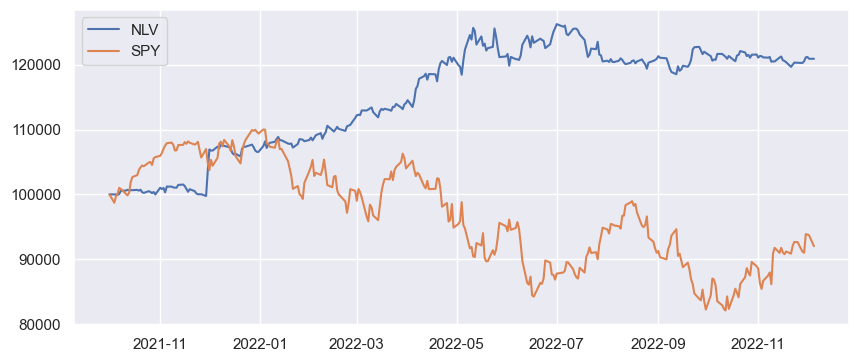

In [14]:
fig = plt.figure(figsize=(10,9))

ax1 = fig.add_subplot(211)

ax1.plot(df_test["net_liquidation_value"], label = "NLV")
ax1.plot(df_test["benchmark"], label = "SPY")

ax1.legend()

In [28]:
fast_test.position_history_df["realized_pl"].sum()

12847.104429948467

In [17]:
df_test["net_liquidation_value"][-1] - df_test["net_liquidation_value"][0]

20908.792679189995